In [ ]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm

# Intro to neural networks 
This notebook relies heavily on the SEG Geophysical Tutorial from August 2018 by Graham Ganssle: https://github.com/seg/tutorials-2018.

The idea is to introduce the based components of an artificial neural network and implement a simple version of one using Numpy.

A neural network is nothing but a nonlinear system of equations like $\mathbf{y} = \sigma(\mathbf{W}\mathbf{x} + \mathbf{b})$.

There are multiple functions $\sigma$ that are used to introduce the non-linear component. One of the most popular functions is the _sigmoid_, aka _logistic_, function:

$$ \sigma(z) = \frac{1}{1 + \operatorname{e}^{-z}} $$

It's derivative is:

$$ \frac{\partial \sigma(z)}{\partial z} = \sigma(z)  (1 - \sigma(z)) $$

We need the derivative for the _backpropagation_ process that enables neural networks to learn efficiently. Backpropagation adjusts the parameters of the neural network by injecting an error signal backwards through the network's layers, from the last to the first.

The sigmoid function looks like this in Python:

In [ ]:
def sigma(z, forward=True):
    if forward:
        return 1 / (1 + np.exp(-z))
    else:
        return z * (1 - z) # note that this is not the actual derivative

The function transforms, or 'squashes', numbers into the range [0, 1] and looks like this:

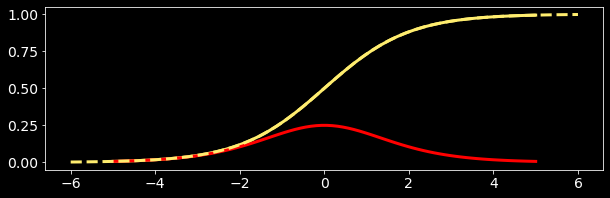

In [45]:
fig, ax = plt.subplots(figsize=(10, 3))

# Solid line.
x = np.linspace(-5, 5)
y = sigma(x)
ax.plot(x, y, color='C9', lw=3)

# Red line, the derivative
x = np.linspace(-5, 5, 80)
y = sigma(sigma(x), forward=False)
ax.plot(x, y, color='r', lw=3)

# Dotted line.
x_ = np.linspace(-6, 6, 80)
y_ = sigma(x_)
ax.plot(x_, y_, '--', color='C9',lw=3)

ax.set_ylim(-0.05, 1.05)
ax.axvline(0, color='k', lw=0.75, zorder=0)
ax.grid(color='k', alpha=0.3)
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()

Other common activation functions include the $\operatorname{tanh}$ function and the ReLU, or rectified linear unit, function:

In [4]:
def tanh(z, forward=True):
    if forward:
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z)) 
    else:
        return 1 - tanh(z)**2

In [5]:
def relu(z, forward=True):
    if forward:
        return z * (z > 0) 
    else:
        return 1 * (z > 0)

## Defining a network

A typical neural network consist of three or more _layers_: an input layer, one or more _hidden_ layers, and an output layer.

Let's implement a network with one hidden layer. The layers are as follows:

$$ \text{Input layer:}\ \ \mathbf{x}^{(i)} $$

$$ \text{Hidden layer:}\ \ \mathbf{a}_1^{(i)} = \sigma ( \mathbf{W}_1 \mathbf{x}^{(i)} + \mathbf{b}_1) $$

$$ \text{Output layer:}\ \ \hat{\mathbf{y}}^{(i)} = \mathbf{W}_2 \mathbf{a}_1^{(i)} + \mathbf{b}_2 $$

where $\mathbf{x}^{(i)}$ is the $i$-th sample of the input data $\mathbf{X}$. $\mathbf{W}_1, \mathbf{b}_1, \mathbf{W}_2, \mathbf{b}_2$ are the weight matrices and bias vectors for layers 1 and 2 respectively, and $\sigma$ is our nonlinear function. Applying the nonlinearity to $\mathbf{W}_1 \mathbf{x}^{(i)} + \mathbf{b}_1$ in layer 1 results in the _activation_ $\mathbf{a}_1$. The output layer yields $\hat{\mathbf{y}}^{(i)}$, the $i$-th estimate of the desired output. We're not going to apply the nonlinearity to the output, but people often do. The weights are randomly initialized and the biases start at zero; during training they will be iteratively updated to encourage the network to converge on an optimal approximation to the expected output.


Note that these are vector operations. In `Numpy` we can easily deal with this because the library understands proper matrix operations. For example, matrix multiplication is done through the `@` operator.

A forward pass of the data through the network looks like this:

In [6]:
def forward(xi, W1, b1, W2, b2):
    z1 = W1 @ xi + b1
    a1 = sigma(z1)
    z2 = W2 @ a1 + b2
    return z2, a1

Below is a picture of a neural network similar to the one we're building:

![image](./images/figure_1.png)

Just like in the SEG tutorial, we'll train a model like this to learn the reflectivity for P–P reflections at an interface. (Normally we'd use the Zoeppritz equation to do this &mdash; our only purpose here is to show that even a simple neural network can learn a nonlinear function. We wouldn't really want to compute the reflectivity this way.)

Instead of 3 inputs, we'll use 7: $V_\mathrm{P}$, $V_\mathrm{S}$ and $\rho$ for the upper and lower layer properties at each interface, plus the angle of incidence, $\theta$ at each interface. And instead of 5 units in the hidden layer, we'll use 300. 

How does the network "learn?" The short version is that we show the system a bunch of corresponding input/output pairs we want it to learn, and we show it these pairs thousands of times. Every time we do so, we move the **W**'s and **b**'s in whatever direction makes the outputs of the network more similar to the known output we're trying to teach it. 

    For each training example:
        For each layer:
          - Calculate the error.
          - Calculate weight gradient.
          - Update weights.
          - Calculate the bias gradient.
          - Update biases.

This is straightforward for the output layer. However, to calculate the gradient at the hidden layer, we need to compute the gradient of the error with respect to the weights and biases of the hidden layer. That's why we needed the derivative in the `forward()` function.

Let's implement this as a Python function:

In [7]:
def backward(xi, yi,
             a1, z2,
             params,
             learning_rate):

    err_output = z2 - yi
    grad_W2 = err_output * a1
    params['W2'] -= learning_rate * grad_W2

    grad_b2 = err_output
    params['b2'] -= learning_rate * grad_b2

    derivative = sigma(a1, forward=False)
    err_hidden = err_output * derivative * params['W2']
    grad_W1 = err_hidden[:, None] @ xi[None, :]
    params['W1'] -= learning_rate * grad_W1
    
    grad_b1 = err_hidden
    params['b1'] -= learning_rate * grad_b1
    
    return params

The trick with the `None` indexing is the same as reshaping the array. We have to do this to produce a 2D array for the `W1` gradients.

To demonstrate this backpropagation workflow, and thus that our system can learn, let's try to get the above neural network to learn the Zoeppritz equation. We're going to need some data.

## Training data

We could make up some data, but it's more fun to use real logs. We'll use the R-39 well from offshore Nova Scotia.

In [46]:
X_train = np.load('./data/numpy_nn/X_train.npy')
y_train = np.load('./data/numpy_nn/y_train.npy')
X_val = np.load('./data/numpy_nn/X_val.npy')
y_val = np.load('./data/numpy_nn/y_val.npy')

Here are the logs and the reflectivity series we're training on:

![image](../images/figure_2.png)


In [47]:
X_train.shape, X_val.shape

((400, 7), (100, 7))

After processing the data and reserving 20% of it for for validation testing, we have a feature matrix `X` with shape 400 &times; 7, and a label vector `y` with 400 elements. The feature matrix has one row for each data sample, and one column for each feature. The features are $V_\mathrm{P}$, $V_\mathrm{S}$, and $\rho$ for the upper and lower layer at each sample, plus the angle of incidence &mdash; 7 features in all. The labels in `y` are the reflectivities calculated from each set of features.

## Train the network

Now we can initialize the weights and biases for our network. A common approach is to initialize the weights with small random numbers (with NumPy's `randn()` function) and the biases with zeros:

In [48]:
def initialize_params(features, units, seed=42):
    np.random.seed(seed)
    params = {
        "W1": 0.1 * np.random.randn(units, features),
        "b1": np.zeros(shape=units),

        "W2": 0.1 * np.random.randn(units),
        "b2": np.zeros(shape=1)
    }
    return params

In [49]:
features = X_train.shape[-1]
units = 300  # Units in hidden layer.

params = initialize_params(features, units)

We're going to need a `predict` function, to make inferences from the trained network.

In [50]:
def predict(X, forward, params):
    """
    Make a prediction for a given input ``X``
    using function ``forward``.
    """
    y_hat = []
    for xi in X:
        yi, _ = forward(xi, **params)
        y_hat.append(yi.item())
    return np.array(y_hat)

Right away, we can pass the data through the untrained network. It won't predict anything useful &mdash; it's just a random combination of the inputs &mdash; but we can look at the result later to see the difference the training made.

In [51]:
pre_train = predict(X_train, forward, params)
pre_val = predict(X_val, forward, params)

During training, we expose the network to the input/output pairs one at a time. These pairs are called `xi` and `yi` respectively in the code. According to our diagram above, the input goes into the green slots and we adjust the orange neurons to make the red slot output from the network a tiny bit closer to the true Zoeppritz result.

We do this many times. Every time we do, we calculate the mean squared error between the network's prediction and the ground-truth output. After many iterations, or _epochs_, we draw a plot which shows the total error, or loss, at each step. If the network is learning anything, we expect the loss to decrease, as the predictions are getting closer to the ground truth.

In [52]:
# Be sure to re-run this before re-training the network!
params = initialize_params(features, units)

In [53]:
num_epochs = 100
learning_rate = 0.001
loss_history, loss_val_history = [], []

data = list(zip(X_train, y_train))
data_val = list(zip(X_val, y_val))

for i in tqdm(range(num_epochs)):
    
    # Validation.
    # We do this first to get the same training state
    # as for the training data (below).
    np.random.shuffle(data_val)
    loss = 0

    for xi, yi in data_val:
        z2, a1 = forward(xi, **params)
        loss += np.square(z2 - yi)

    loss_val_history.append(loss/y_val.size)
    
    # Training.
    np.random.shuffle(data)
    loss = 0
    
    for xi, yi in data:
        z2, a1 = forward(xi, **params)

        params = backward(xi, yi,
                          a1, z2,
                          params,
                          learning_rate)
        
        loss += np.square(z2 - yi)

    loss_history.append(loss/y_train.size)

100%|██████████| 100/100 [00:01<00:00, 56.31it/s]


The parameters of the model are now no longer random.

In [54]:
params

{'W1': array([[ 0.04911706, -0.01382902,  0.06281514, ..., -0.02397371,
         -0.02216726,  0.15800587],
        [ 0.07802141, -0.04686259,  0.05883635, ..., -0.04517443,
          0.02120033, -0.1915259 ],
        [-0.17149539, -0.05629312, -0.09727381, ..., -0.08958568,
         -0.14390875,  0.14642336],
        ...,
        [-0.04313921,  0.00123639,  0.0648199 , ..., -0.22743341,
         -0.05794162, -0.12232816],
        [-0.051186  , -0.01481036, -0.04660903, ...,  0.03216513,
          0.03089594,  0.06228475],
        [-0.1139821 ,  0.10391525, -0.00793724, ..., -0.1072789 ,
         -0.15515524,  0.08180663]]),
 'b1': array([-4.45108400e-06,  6.30188448e-06,  3.93607712e-05, -3.67412502e-05,
         3.70954589e-06, -4.01880978e-05, -2.63596835e-05,  4.75245781e-05,
        -7.02827888e-06, -1.00306381e-06, -1.03056682e-04, -6.95005660e-07,
         1.70658685e-06,  2.11271150e-06, -3.85096567e-05, -1.80515643e-05,
         1.47764654e-05, -5.92696434e-05,  2.02243273e-04

In [0]:
fig, ax = plt.subplots(figsize=(10,3))

ax.semilogy(loss_history, label='Training loss')
ax.semilogy(loss_val_history, label='Validation loss')

ax.set_title('Mean squared error vs epoch number', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid()
ax.legend(fontsize=14)

plt.tight_layout()
plt.show()

The loss decreased dramatically over the course of 100 epochs, so presumably the network has learned something. To test this theory, let's plot the first 100 network outputs before (green) and after (orange) training and compare them to the expected result (blue):

In [55]:
post_train = predict(X_train, forward, params)

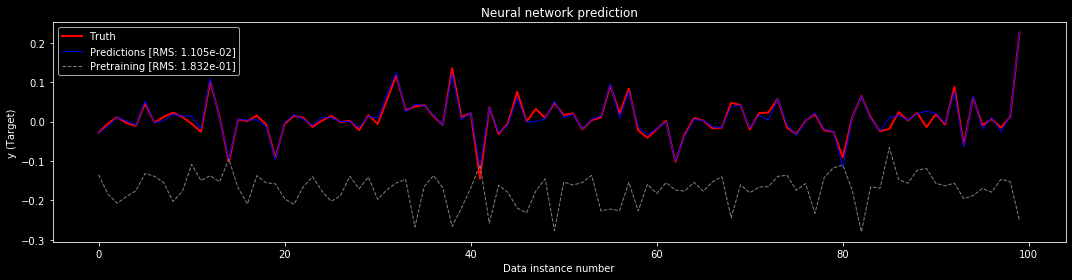

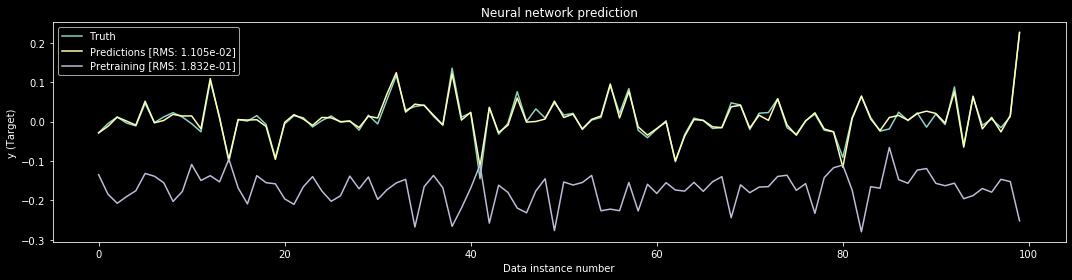

In [66]:
from utils import plot_result

plot_result(y_train, post_train, pre_train,
             labels=['Truth', 'Predictions', 'Pretraining'],
             styles=['-', '-', '--'],
             colours=['r', 'b', 'gray'],
             lws=[2,1,1])

plot_result(y_train, post_train, pre_train,labels=['Truth', 'Predictions', 'Pretraining'])

c:\Users\meham\Desktop\development projects\machine_learning_agile\geocomp-ml\notebooks


To see how well the network predicts data it was not trained on, we can compare the output from the validation set with the ground truth:

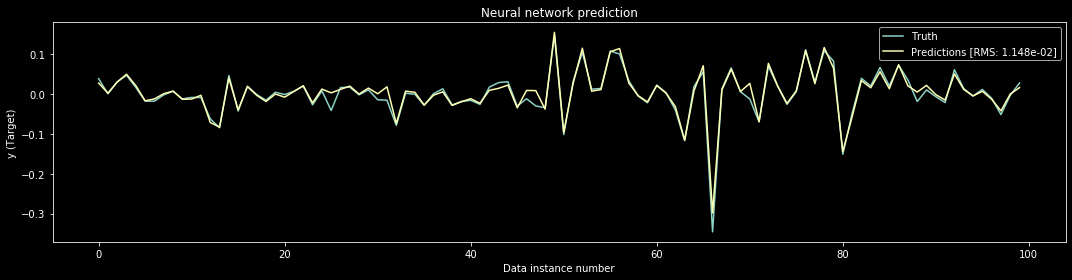

In [67]:
y_val_numpy = predict(X_val, forward, params)

plot_result(y_val, y_val_numpy,
            labels=['Truth', 'Predictions'])

## Blind test 1: new rocks

The chart above shows the result of applying the neural network to data that it was not directly trained on, but is from the same rocks that we trained on. Let's test the network on more different data to what it has seen before. We'll use the higher-impedance rocks from near the bottom of the same well &mdash; we say that the data are outside the _span of the input domain_.

In [68]:
X_blind = np.load('../data/numpy_nn/X_blind.npy')
y_blind = np.load('../data/numpy_nn/y_blind.npy')

In [69]:
y_blind_numpy = predict(X_blind, forward, params)

In the plot below, the blue line is the true Zoeppritz result and the orange line is the output from the network after training (i.e. after the weights have been learned).

In [0]:
plot_result(y_blind, y_blind_numpy,
            labels=['Truth', 'NumPy'])

So, indeed, our neural network has learned to approximate the Zoeppritz equation, and that it generalizes to rocks it did not see during training.

## Blind test 2: new angles

**You need `bruges` for this part; install it with `pip install bruges`. **

The data only contains near-angle reflectivities, with incidence angles from 0 up to 20 degrees. But we'd often like to know reflectivity for wider angles than this, even up to about 60 degrees. How well does our model perform on those angles, given that it has never been exposed to reflectivity like that?

To find out, we'll look at the AVO response at a single interface and see how it compares to the exact solution. We need the unscaled test data in order to compute the full Zoeppritz reflectivities at each data sample. We can recover them from the scaled data:

In [70]:
import joblib
scaler = joblib.load('../data/numpy_nn/scaler.pkl') 

X_blind_unscaled = scaler.inverse_transform(X_blind)

We'd like to confirm the range of `theta` the training data contained:

In [71]:
theta_ = scaler.inverse_transform(X_train)[:, -1]

min_theta, max_theta = np.min(theta_), np.max(theta_)

print(f"Training data range for theta: {min_theta:.2f} to {max_theta:.2f} degrees")

Training data range for theta: 0.10 to 19.86 degrees


Let's write a function to take a single instance of a feature vector, plus one or more angles, plus our model, plus the scaling function used to standardize the data, and return 2 things:

1. The reflectivity computed with the Zoeppritz equation.
1. The reflectivity predicted with the model.

In [72]:
from bruges.reflection import zoeppritz_rpp

def get_reflectivity(xi, theta, forward, params, scaler):
    """
    Get Zoeppritz reflectivity (ground truth) and predicted
    reflectivity for a particular data instance (i.e. one depth sample).
    
    Args
    ----
    xi (array-like): One instance of X containing Vp, Vs, rho for
        the upper and lower layers.
    theta (array-like): The values of theta to compute reflectivity
        for.
    forward (function): The function implementing the forward pass.
    params (dict): The parameters (weights) of the model.
    scaler (sklearn.preprocessing.Scaler): The scaler matching the
        forward function.
        
    Returns
    -------
    (float, float): Tuple of the actual reflectivity and the predicted
        reflectivity.
    """
    theta = np.atleast_1d(theta)

    # Compute actual reflectivity.
    r = zoeppritz_rpp(*xi[:-1], theta1=theta).real

    # Predict reflectivity using neural net.
    r_hat = []
    for t in theta:
        xi_ = np.hstack([xi[:-1], t])
        xi_ = scaler.transform(xi_.reshape(1, -1))
        r_, _ = forward(np.squeeze(xi_), **params)
        r_hat.append(r_)
        
    return r, r_hat

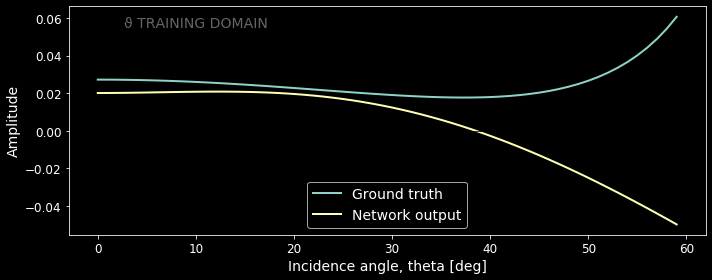

In [73]:
theta = np.arange(60)
sample = 35

r, r_hat = get_reflectivity(X_blind_unscaled[sample],
                            theta=theta,
                            forward=forward,
                            params=params,
                            scaler=scaler,
                           )

from utils import plot_zoeppritz

plot_zoeppritz(theta, r, r_hat, min_theta, max_theta)

<div class="alert alert-success">
----

<h3>Optional exercises</h3>

Try to do these exercises on the NumPy implementation above. But if that proves too difficult, use the TensorFlow implementation below.

- Turn the prediction loop into a function called `fit`.
- Try changing the model parameters, for example using fewer units in the hidden layer. Does this help?
- Train the model on larger angles; measure the increase in performance in prediction on those angles.
- Add another layer to the model. Does this help?
- Try using other activation functions than the sigmoid function we're currently using.
- See if you can get TensorFlow's SGD optimizer to work like PyTorch's :)

<h3>OOP challenge</h3>

- If you've taken the Mastery class, or know about object oriented programming, write a Python `class` to hold the NumPy implementation. Copy the `keras`/`sklearn` interface as closely as possible. Related: [this awesome video from Joel Grus](https://www.youtube.com/watch?v=o64FV-ez6Gw).
</div>

----

## How does that network look using `tensorflow`?

In [74]:
import tensorflow as tf

In [75]:
# Model architecture.
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(7, input_dim=7))
model.add(tf.keras.layers.Dense(300, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1))

# Optimizer. Try Adam with a larger batch size.
sgd = tf.keras.optimizers.SGD(lr=1e-3)

# Compile the graph.
model.compile(loss='mse',
              optimizer=sgd,
              metrics=['mse'])

In [76]:
model.fit(X_train, y_train,
          epochs=100,
          batch_size=1,
          validation_data=(X_val, y_val),
         )

e-0146/400 [=========>....................] - ETA: 0s - loss: 4.4686e-04 - mse: 4.4686e-0170/400 [===========>..................] - ETA: 0s - loss: 4.1184e-04 - mse: 4.1184e-0193/400 [=============>................] - ETA: 0s - loss: 4.6306e-04 - mse: 4.6306e-0216/400 [===============>..............] - ETA: 0s - loss: 4.5289e-04 - mse: 4.5289e-0236/400 [================>.............] - ETA: 0s - loss: 4.4161e-04 - mse: 4.4161e-0262/400 [==================>...........] - ETA: 0s - loss: 4.2186e-04 - mse: 4.2186e-0282/400 [====================>.........] - ETA: 0s - loss: 4.1292e-04 - mse: 4.1292e-0306/400 [=====================>........] - ETA: 0s - loss: 4.8549e-04 - mse: 4.8549e-0330/400 [=======================>......] - ETA: 0s - loss: 4.7493e-04 - mse: 4.7493e-0355/400 [=========================>....] - ETA: 0s - loss: 4.6795e-04 - mse: 4.6795e-0382/400 [===========================>..] - ETA: 0s - loss: 4.7495e-04 - mse: 4.7495e-0400/400 [==============================] - 1s 2ms/s

In [ ]:
y_val_tf = np.squeeze(model.predict(X_val))

In [ ]:
plot_result(y_val, y_val_numpy, y_val_tf, labels=['Truth', 'NumPy', 'Tensorflow'])

### On blind data

Let's look at the blind data (rocks the network was not trained on). We'll plot the previous effort (the NumPy network) in green for comparison.

In [0]:
y_blind_tf = np.squeeze(model.predict(X_blind))

plot_result(y_blind, y_blind_numpy, y_blind_tf,
            labels=['Truth', 'NumPy', 'TensorFlow'])

----

## How does it look in `torch.nn`?

In [0]:
import torch
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [0]:
class Net(nn.Module):
    def __init__(self, inputSize=7, hiddenSize=300, outputSize=1):
        super().__init__()
        
        self.inputSize = inputSize
        self.hiddenSize = hiddenSize
        self.outputSize = outputSize

        self.fc1 = nn.Linear(self.inputSize, self.hiddenSize)
        self.fc2 = nn.Linear(self.hiddenSize, self.outputSize)
        
    def forward(self, X):
        a1 = torch.sigmoid(self.fc1(X))
        z2 = self.fc2(a1)  # No activation
        return z2
    
net = Net()
net.to(device)
print(net)

In [0]:
import torch.utils.data as utils

X_train_ = torch.tensor(X_train, dtype=torch.float).to(device)
y_train_ = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float).to(device)

traindata = utils.TensorDataset(X_train_, y_train_)
trainloader = utils.DataLoader(traindata)

In [0]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [0]:
epochs = 100

for epoch in range(epochs):
    epoch_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"# {epoch+1}  Loss {epoch_loss}")
print('Finished Training')

In [0]:
X_val_ = torch.tensor(X_val, dtype=torch.float).to(device)
y_val_ = torch.tensor(y_val.reshape(-1, 1), dtype=torch.float).to(device)

valdata = utils.TensorDataset(X_val_, y_val_)
valloader = utils.DataLoader(valdata)

In [0]:
y_val_torch = [float(net(xi)) for xi, yi in valloader]

The network performs very similarly to the NumPy implelementation.

In [0]:
plot_result(y_val, y_val_numpy, y_val_tf, y_val_torch,
            labels=['Truth', 'NumPy', 'TensorFlow', 'PyTorch'])

### On blind data

In [0]:
X_blind_ = torch.tensor(X_blind, dtype=torch.float).to(device)
y_blind_ = torch.tensor(y_blind.reshape(-1, 1), dtype=torch.float).to(device)

blinddata = utils.TensorDataset(X_blind_, y_blind_)
blindloader = utils.DataLoader(blinddata)

In [0]:
y_blind_pytorch = [float(net(xi)) for xi, yi in blindloader]

In [0]:
plot_result(y_blind, y_blind_numpy, y_blind_tf, y_blind_pytorch,
            labels=['Truth', 'NumPy', 'TensorFlow', 'PyTorch'])

## Other types of neural networks

![image](../images/nn_arch_cheatsheet.png)